# Sales Conversion Optimization

In this notebook a Sales Conversion Optimization Analysis is performed.
The data is taken from 3 different facebook ad campaigns. 
The aim of the campaign is assumed to be profit, we therefore take number of conversions as indicator for success.

The present analysis will look at relationships within the data, and then try to fit a machine learning model to predict conversion success of individual campaigns.


Link to kaggle challenge:

*https://www.kaggle.com/datasets/loveall/clicks-conversion-tracking?resource=download*

----

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
## importing the dataset
data = pd.read_csv('data/KAG_conversion_data.csv')
data.shape

(1143, 11)

## 1. Data Cleaning

In [3]:
## dropping unnecessary columns
data.drop("fb_campaign_id", axis=1, inplace=True)

### 2.1 Missing Values

In [4]:
## inspecting missing values
data.isnull().sum()

ad_id                  0
xyz_campaign_id        0
age                    0
gender                 0
interest               0
Impressions            0
Clicks                 0
Spent                  0
Total_Conversion       0
Approved_Conversion    0
dtype: int64

### 2.2 Duplicates

In [5]:
## inspecting duplicates
data.duplicated().sum()

0

### 2.3 Outliers

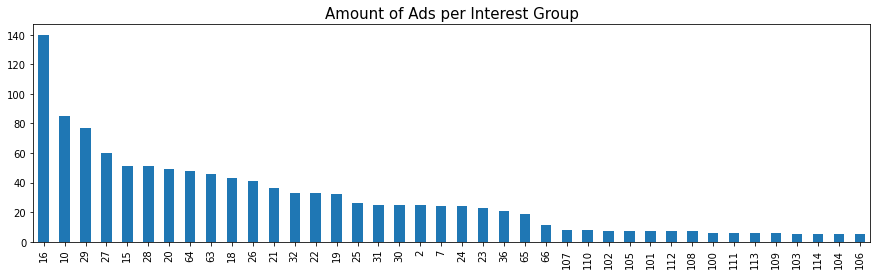

In [6]:
## checking for outliers in 'interest'
plt.figure(figsize=(15,4))
data.interest.value_counts().plot(kind="bar")
plt.title("Amount of Ads per Interest Group", size=15);

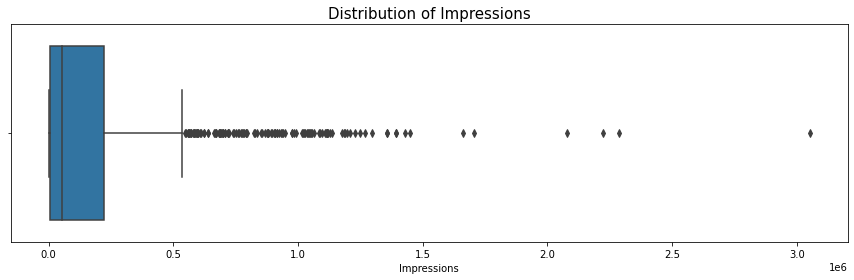

In [7]:
## checking for outliers in Impressions
plt.figure(figsize=(15,4))
sns.boxplot(x=data.Impressions)
plt.title("Distribution of Impressions", size=15);

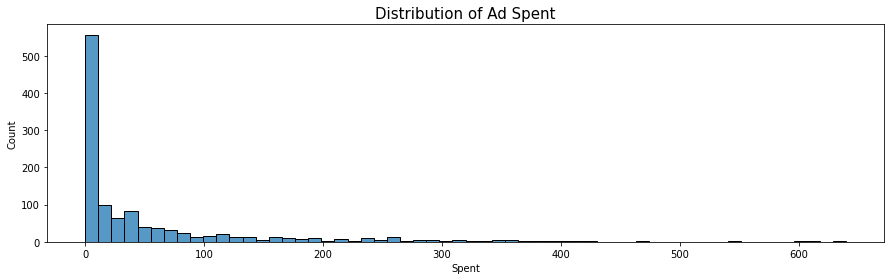

In [8]:
## checking for outliers in 'Spent'
plt.figure(figsize=(15,4))
sns.histplot(x=data.Spent)
plt.title("Distribution of Ad Spent", size=15);

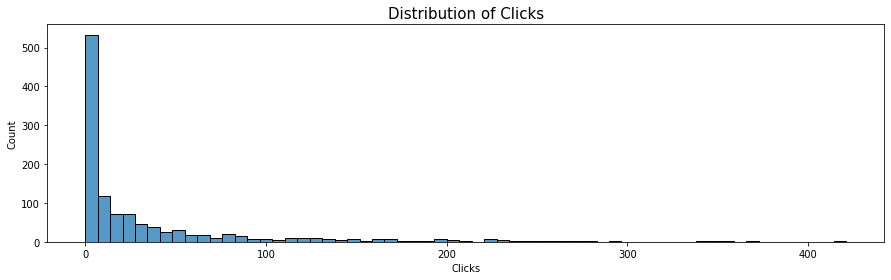

In [9]:
## checking for outliers in 'Clicks'
plt.figure(figsize=(15,4))
sns.histplot(x=data.Clicks)
plt.title("Distribution of Clicks", size=15);

In [10]:
## Inspecting Outliers
data.sort_values(by="Clicks", ascending=False)[:5]

,ad_id,xyz_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion
860,1121814,1178,30-34,F,27,2223278,421,612.300003,38,13
1026,1122265,1178,45-49,F,27,1428421,367,541.700002,10,0
765,1121601,1178,45-49,M,16,2286228,353,603.380002,16,7
995,1122193,1178,45-49,F,10,1358324,346,465.079998,8,2
525,1121100,1178,30-34,M,15,3052003,340,639.949998,60,17


(Outliers appear to be valid data points, and are therefore left in the dataset)

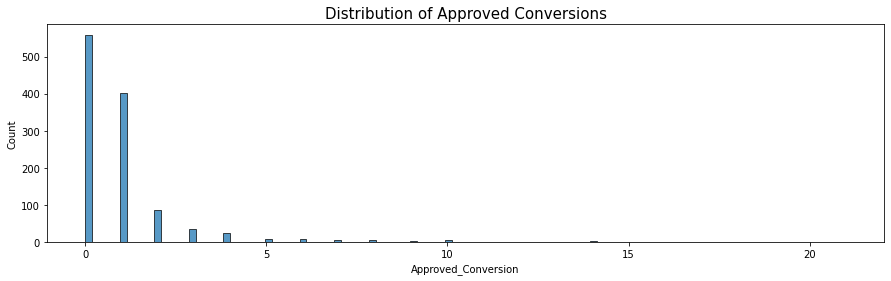

In [11]:
## checking outliers for conversions
plt.figure(figsize=(15,4))
sns.histplot(x=data.Approved_Conversion)
plt.title("Distribution of Approved Conversions", size=15);

**Notes:**

The distributions for all continuous variables are highly skewed, with some extreme values compared to measures of centrality. The data appears to be real however, and represents actual distributions / phenomena (such as increases in ad spend correlating with increases in Impressions and Conversions; correlations are examined in the next section). 

These observations are therefore left in the dataset.

In [12]:
## changing values for campaign id
data["xyz_campaign_id"].replace({916:"campaign_a" ,936:"campaign_b" ,1178:"campaign_c"}, inplace=True)

## 2. Exploraroty Analysis

This section is analysing some interesting distributions and trends, such as ..

1. How many ads are there per ad - campaign?
2. How well do the campaigns perform compared to the others?
3. What is the average Ad Spent?
4. What is the correlation between Ad Spent, Impressions and Conversions?
5. Is there a linear relationship between Ad Spent and Impressions?

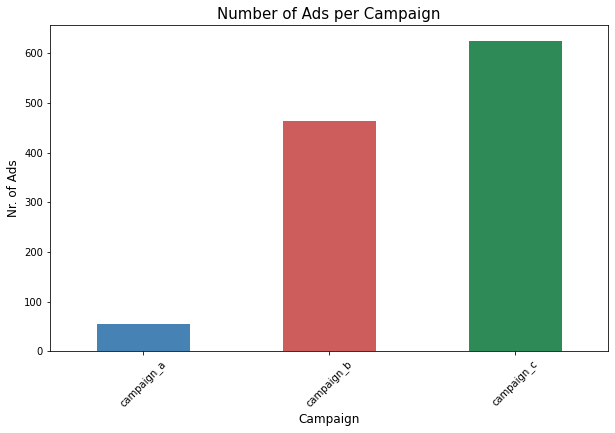

In [13]:
## Assessing number of ads per campaign
plt.figure(figsize=(10,6))
data.groupby("xyz_campaign_id")["ad_id"].nunique().plot(kind="bar", color=["steelblue", 
                                                                           "indianred", 
                                                                           "seagreen"])
plt.xticks(rotation=45)
plt.title("Number of Ads per Campaign", size=15)
plt.xlabel("Campaign", size=12)
plt.ylabel("Nr. of Ads", size=12);

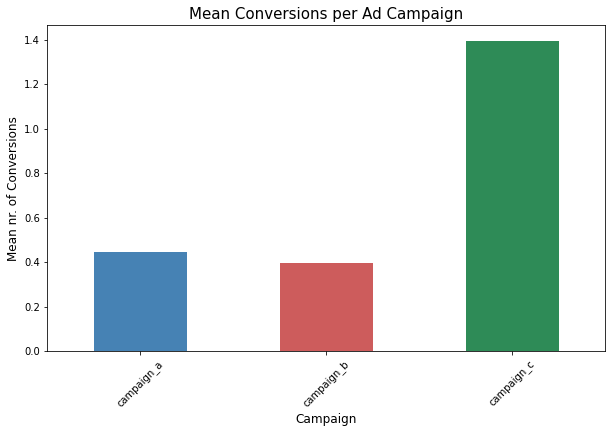

In [14]:
## assessing the relative performance of the campaigns, based on conversion success

plt.figure(figsize=(10,6))
data.groupby("xyz_campaign_id")["Approved_Conversion"].mean().plot(kind="bar", color=["steelblue", 
                                                                                      "indianred", 
                                                                                      "seagreen"])
plt.xticks(rotation=45)
plt.title("Mean Conversions per Ad Campaign", size=15)
plt.xlabel("Campaign", size=12)
plt.ylabel("Mean nr. of Conversions", size=12);

In [15]:
avg = round(data.Spent.median(),2)

print()
print(f'Average amount (median, due to skew) spent per ad: \033[1m{avg}\033[0m')
print()


Average amount (median, due to skew) spent per ad: 12.37



<AxesSubplot:>

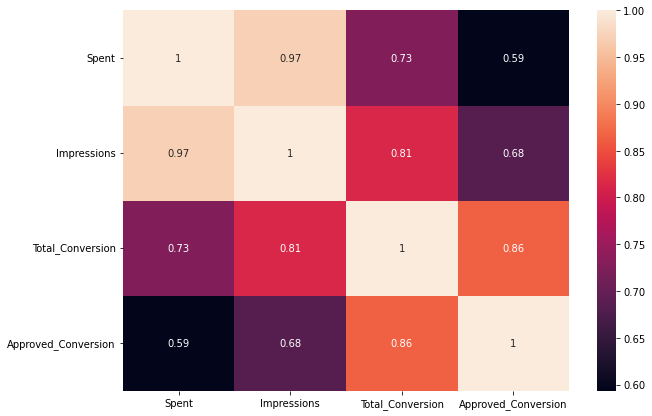

In [16]:
## assessing the relationship between Ad Spent, nr. of Impressions and Conversions
tmp = data[["Spent", "Impressions", "Total_Conversion", "Approved_Conversion"]].corr()

plt.figure(figsize=(10,7))
sns.heatmap(tmp, annot=True)

**Notes:**

There is a very clear relationship between Ad Spent and Impressions, as well as with Conversions.

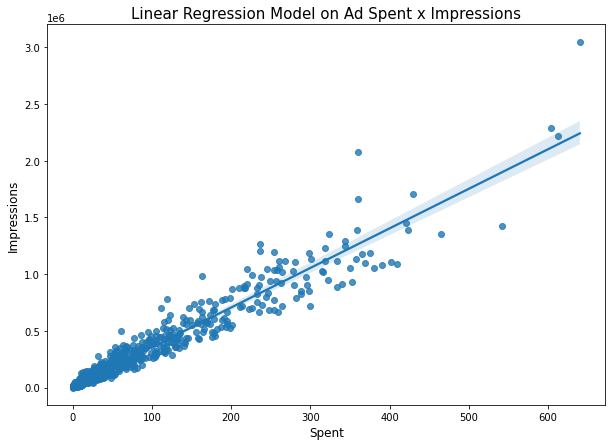

In [17]:
## Is there a relationship between Ad Spend and Conversion?
plt.figure(figsize=(10,7))

sns.regplot(x = "Spent",
            y= "Impressions",
           data= data)

plt.title("Linear Regression Model on Ad Spent x Impressions", size= 15)
plt.xlabel("Spent", size=12)
plt.ylabel("Impressions", size=12);

## 3. Feature Engineering

Calculating *Click-Through-Rate* and *Cost per Click* as additional features for our model.

To prevent data leakage (i.e. having the target values be represented in training features),
we will abstain from calculating *Conversion Rate* and *Cost per Conversion*.

In [18]:
## calculating click-through-rate
data["CTR (%)"] = (data["Clicks"] / data["Impressions"]) * 100

In [19]:
## calculating Cost per Click
mask = (data["Clicks"] != 0)
data_valid = data[mask]

data["CpC"] = 0

data.loc[mask, "CpC"] = data["Clicks"] / data["Spent"]

In [20]:
data.head(3)

,ad_id,xyz_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,CTR (%),CpC
0,708746,campaign_a,30-34,M,15,7350,1,1.43,2,1,0.013605,0.699301
1,708749,campaign_a,30-34,M,16,17861,2,1.82,2,0,0.011198,1.098901
2,708771,campaign_a,30-34,M,20,693,0,0.00,1,0,0.000000,0.000000


## 4. Data Preprocessing

To prevent data leakage, the datasets for training and evaluation (X_train, X_test, respectively) are scaled separately.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [22]:
## making a separate but identical dataframe to preprocess, in order to preserve the original data
processed_data = data.copy()

In [23]:
## Splitting train and test data to avoid data leakage
X = processed_data.drop(["Total_Conversion", "Approved_Conversion"], axis= 1)
y = processed_data["Approved_Conversion"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size= 0.33,
                                                    random_state= 0)

In [24]:
## creating function to one hot encode all categorical features in the dataset
def ohe(dataframe):

    encoder = OneHotEncoder(sparse= False)

    for col in ["xyz_campaign_id", "age", "gender"]:

        encoder.fit(dataframe[[col]])

        col_encoded = encoder.transform(dataframe[[col]])

        dataframe[encoder.categories_[0]] = col_encoded

        dataframe.drop(columns=[col], inplace=True)
        
    return dataframe

## creating function to scale all continuous features of the dataset
def minmaxscale(dataframe):
    
    scaler = MinMaxScaler()

    for col in ["Impressions","interest", "Spent", "Clicks", "CTR (%)", "CpC"]:

        scaler.fit(dataframe[[col]])

        dataframe[col] = scaler.transform(dataframe[[col]])
        
    return dataframe

In [25]:
## feature scaling X_train
X_train = ohe(X_train)
X_train = minmaxscale(X_train)

In [26]:
X_train.head(3)

,ad_id,interest,Impressions,Clicks,Spent,CTR (%),CpC,campaign_a,campaign_b,campaign_c,30-34,35-39,40-44,45-49,F,M
95,735033,0.303571,0.000185,0.000000,0.000000,0.000000,0.00000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
113,736890,0.116071,0.000798,0.000000,0.000000,0.000000,0.00000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
918,1121931,0.178571,0.025683,0.040872,0.036956,0.226239,0.15222,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [27]:
## feature scaling X_test
X_test = ohe(X_test)
X_test = minmaxscale(X_test)

In [28]:
X_test.head(3)

,ad_id,interest,Impressions,Clicks,Spent,CTR (%),CpC,campaign_a,campaign_b,campaign_c,30-34,35-39,40-44,45-49,F,M
946,1122039,0.071429,0.116373,0.144893,0.134379,0.222372,0.133447,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
142,738463,0.169643,0.000129,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
934,1121977,0.241071,0.062681,0.061758,0.069263,0.175822,0.110351,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


## 5. Modeling

In [29]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_validate

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [30]:
## comparing regressors to decide which model is most performant, to later be selected as final model
## models are evaluated on the training dataset
regressors = [DecisionTreeRegressor(), 
              LinearRegression(), 
              KNeighborsRegressor(), 
              Lasso(),
              ElasticNet(), 
              RandomForestRegressor()]

comparison_df = []

for reg in regressors:
    
    model = reg
    
    cv_result = cross_validate(reg, 
                               X_train, 
                               y_train, 
                               cv= 5, 
                               scoring=["r2"])
    
    r2 = cv_result["test_r2"].mean()
    
    stats = {"Name": str(reg),
            "r2": r2}
    
    comparison_df.append(stats)
    
results_df = pd.DataFrame(comparison_df)
results_df["r2"] = results_df["r2"].apply(lambda x: '%.5f' % x)

results_df.sort_values(by="r2", ascending=False)

,Name,r2
1,LinearRegression(),0.51660
5,RandomForestRegressor(),0.46410
3,Lasso(),0.06962
4,ElasticNet(),0.06962
2,KNeighborsRegressor(),-0.15978
0,DecisionTreeRegressor(),-0.01174


Due to the observed performance of the different algorithms above, a regular multivariate **LinearRegression()** algorithm is chosen as the final algorithm.

In [31]:
## performing a Grid Search on RandomForestRegressor to tune hyperparameters, 
## to see whether it improves model performance
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()

grid = {
    'n_estimators': [100, 250, 500, 1000],
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'max_features': ["log2", "sqrt"]
}

search = GridSearchCV(rf,
                     grid,
                     scoring= 'r2',
                      cv= 5,
                      n_jobs= -1
                     )

search.fit(X_train, y_train)

bs = search.best_score_
bp = search.best_params_

In [32]:
## showing the score and parameters of the best performant model
overview = {
    "best score": bs,
    "best params": bp,
}

overview

{'best score': 0.4922874536224559,
 'best params': {'criterion': 'poisson',
  'max_features': 'log2',
  'n_estimators': 500}}

Even after Hyperparameter Tuning, the regular LinearRegression() model performs better than the RandomForestRegressor(). It is therefore chosen as the final model

In [33]:
## performing feature permutation to improve model performance
from sklearn.inspection import permutation_importance

lm = LinearRegression().fit(X_train, y_train)

permutation_score = permutation_importance(lm, X_train, y_train, n_repeats=10)

importance_df = pd.DataFrame(np.vstack((X_train.columns,
                                       permutation_score.importances_mean)).T)

importance_df.columns= ["feature", "score decrease"]

importance_df.sort_values(by="score decrease", ascending= False, inplace= True)

importance_df

,feature,score decrease
2,Impressions,6.300637
4,Spent,0.736532
3,Clicks,0.497347
5,CTR (%),0.013353
0,ad_id,0.008904
6,CpC,0.006251
10,30-34,0.004247
1,interest,0.001147
9,campaign_c,0.001049
11,35-39,0.000741


Due to the feature importance indicated above, only "Impressions", "Spent",  and "Clicks" will be kept as input features.

In [34]:
## dropping features without predictive power for y as indicated by feature importance
new_X_train = X_train.drop(importance_df.feature[3:], axis=1)

new_X_train.head(3)

,Impressions,Clicks,Spent
95,0.000185,0.000000,0.000000
113,0.000798,0.000000,0.000000
918,0.025683,0.040872,0.036956


In [35]:
## the test set is adjusted accordingly
new_X_test = X_test.drop(importance_df.feature[3:], axis=1)

In [36]:
## fitting a new LinearRegression() model on the final data
lm = LinearRegression()

lm.fit(new_X_train, y_train)

score = lm.score(new_X_test, y_test)

print(f'The final score (r2) of the Linear regression model is \033[1m{score.round(2)}\033[0m')

The final score (r2) of the Linear regression model is -0.38


As can be seen, the model does not perform well at all at predicting Approved_Conversion from the input features 'Impressions', 'Clicks', and 'Spent'. 

This is likely due to them not having enough predictive power in terms of their real-world relationship, rather than a technical limitation. 

To improve regression accuracy, it is estmated that much more, and qualitatively different data (in terms of the features that are present in the data) would be needed.

## Bonus Section: Building a Classification model

In this Bonus Section, it is attempted to predict whether an ad will have any conversion at all, based on Impression, Clicks and Ad Spent. It is therefore a binary classication task that will be solved by a Machine Learning Classifier.

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [38]:
## data preprocessing
processed_data = data.copy()
processed_data["Conversion"] = processed_data["Approved_Conversion"].apply(lambda x: 1 if x > 0 else 0)

X = processed_data.drop(["Total_Conversion", "Approved_Conversion", "Conversion"], axis= 1)
y = processed_data["Conversion"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size= 0.33,
                                                    random_state= 42)

X_train = ohe(X_train)
X_train = minmaxscale(X_train)

X_test = ohe(X_test)
X_test = minmaxscale(X_test)

X_train, X_test = X_train[["Impressions", "Clicks", "Spent"]], X_test[["Impressions", "Clicks", "Spent"]]

In [39]:
## inspecting the final dataset
X_train.head(3)

,Impressions,Clicks,Spent
204,0.001523,0.000000,0.000000
618,0.004770,0.000000,0.000000
1140,0.066244,0.066508,0.065801


In [40]:
## modeling the classifier
classifiers = [DecisionTreeClassifier(), 
              LogisticRegression(), 
              KNeighborsClassifier(), 
              RandomForestClassifier(),
              LinearSVC()]

comparison_df = []

for clf in classifiers:
    
    model = clf
    
    cv_result = cross_validate(clf, 
                               X_train, 
                               y_train, 
                               cv= 5, 
                               scoring=["accuracy"])
    
    acc = cv_result["test_accuracy"].mean()
    
    stats = {"Name": str(model),
            "acc": acc}
    
    comparison_df.append(stats)
    
results_df = pd.DataFrame(comparison_df)
results_df["acc"] = results_df["acc"].apply(lambda x: '%.5f' % x)

results_df.sort_values(by="acc", ascending=False)

,Name,acc
4,LinearSVC(),0.65359
1,LogisticRegression(),0.64444
2,KNeighborsClassifier(),0.58824
3,RandomForestClassifier(),0.57647
0,DecisionTreeClassifier(),0.57516


In [41]:
## fitting and scoring the LinearSVC()
svc = LinearSVC()

svc.fit(X_train, y_train)

score = svc.score(X_test, y_test)

print(f'The final accuracy of the LinearSVC() is \033[1m{score.round(3)}\033[0m')

The final accuracy of the LinearSVC() is 0.598


# Final Thoughts

As can be seen from the scores of both the regression model, as well as the classifier, predictions of Conversions based on the present dataset have proven unfruitful.

Assumed reason for this is that the data used here contains insufficient information to be able to map patterns within that data onto the desired output variable, namely number of conversions.

In order to achieve somewhat satisfactory prediction accuracy (whether with a regression or classification algorithm), it would be necessary to collect more data of different sources. To identify which data would be needed (especially in terms of features with explanatory power), it is best advised to consult with a domain expert who understands the necessary factors influencing, and correlating with, number of conversions of facebook ads.